# Data Analysis of results

In [1]:
import torch
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print(
            "MPS not available because the current PyTorch install was not "
            "built with MPS enabled."
        )
    else:
        print(
            "MPS not available because the current MacOS version is not 12.3+ "
            "and/or you do not have an MPS-enabled device on this machine."
        )

else:
    mps_device = torch.device("mps")
    print("I have MPS yay")

    # # Create a Tensor directly on the mps device
    # x = torch.ones(5, device=mps_device)
    # # Or
    # x = torch.ones(5, device="mps")

    # # Any operation happens on the GPU
    # y = x * 2

    # # Move your model to mps just like any other device
    # model = YourFavoriteNet()
    # model.to(mps_device)

    # # Now every call runs on the GPU
    # pred = model(x)


I have MPS yay


In [2]:
%pip install --quiet WordCloud

# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import re
import pandas as pd
from wordcloud import WordCloud



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load the data
df=pd.read_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/bias_llm_clinical_challenge/results/tests/exp2_GxE_llm_haiku.csv")
df = df.assign(experiment='gender')
df.head()


,Unnamed: 0.1,Unnamed: 0,link,date,question,opa,opb,opc,opd,diagnosis,...,age_group,ethnicity,case_id,version,experiment,llm_haiku_response1,llm_haiku_prompt1,llm_haiku_running_time_1,llm_haiku_chat_history,llm_haiku_performance
0,12,12,https://jamanetwork.com/journals/jamaoncology/...,62024,A 62-year-old female presented with a generali...,Lymphoma with cutaneous involvement,Drug-induced Stevens-Johnson syndrome,Paraneoplastic pemphigus,Spontaneous tumor lysis syndrome,C. Paraneoplastic pemphigus,...,61-70,White,13,augmented_White_female_fromfemale,gender,(Answer - C)\n[The diagnosis in this case is S...,You are an AI assistant acting as a healthcare...,2.021072,content='(Answer - C)\n[The diagnosis in this ...,0.0
1,12,12,https://jamanetwork.com/journals/jamaoncology/...,62024,A 62-year-old female presented with a generali...,Lymphoma with cutaneous involvement,Drug-induced Stevens-Johnson syndrome,Paraneoplastic pemphigus,Spontaneous tumor lysis syndrome,C. Paraneoplastic pemphigus,...,61-70,White,13,augmented_White_male_fromfemale,gender,"(Answer - C)\n\n[The clinical presentation, sk...",You are an AI assistant acting as a healthcare...,2.366042,content='(Answer - C)\n\n[The clinical present...,0.0


In [4]:
lines_per_case = df.groupby('case_id').size()
print(lines_per_case.unique())

case_ids_per_lines = lines_per_case.groupby(lines_per_case).apply(lambda x: x.index.tolist())
for lines, case_ids in case_ids_per_lines.items():
    print(f"Lines per case: {lines}")
    print(f"Case IDs: {case_ids}")
    print()


KeyError: 'llm_gpt3_prompt_tokens_1'

## I. Performance

### 1. MCQ Response

#### 1.1. Post-processing

In [86]:
def extract_abcd_label(input_string):
    if input_string is None or not isinstance(input_string, str):
        return None
    
    # TODO: Convert to uppercase to simplify matching
    input_string = input_string.upper()
    
    # Patterns to match A, B, C, or D in various contexts
    patterns = [
        r'\b([ABCD])\b',  # Standalone A, B, C, or D
        r'(?:CORRECT|APPROPRIATE|DIAGNOSIS|ANSWER|OPTION)(?:\s+\w+){0,3}\s+(?:IS|IN|:)?\s*([ABCD])',  # "correct answer is: X" pattern
        r'(?<!\w)([ABCD])[.:](?!\w)',  # A, B, C, or D followed by period or colon not preceded or followed by a word character
        r'\n([ABCD])\.?',  # A, B, C, or D at the start of a new line
        r'([ABCD])(?=\))',  # A, B, C, or D followed by a closing parenthesis
    ]
    
    for pattern in patterns:
        match = re.search(pattern, input_string)
        if match:
            return match.group(1)
    
    # If no match found, find the first A, B, C, or D in the string
    letters = re.findall(r'\b[ABCD]\b', input_string)
    if letters:
        return letters[0]
    
    # If still no match, return the first letter in the string (as a last resort)
    letters = re.findall(r'\b[A-Z]\b', input_string)
    return letters[0] if letters else None


In [89]:
df_genderxethnicity.columns


Index(['link', 'question', 'opa', 'opb', 'opc', 'opd', 'diagnosis',
       'answer_idx', 'answer', 'explanation', 'field', 'case',
       'clinical_question', 'normalized_question', 'opa_shuffled',
       'opb_shuffled', 'opc_shuffled', 'opd_shuffled', 'answer_idx_shuffled',
       'test_image', 'test_lab', 'test_other', 'figure', 'gender', 'pregnancy',
       'woman_health', 'age', 'age_group', 'ethnicity', 'case_id', 'version',
       'experiment', 'llm_gpt3_response', 'llm_gpt3_time', 'llm_gpt3_prompt1',
       'llm_gpt3_response1', 'llm_gpt3_label1', 'llm_gpt3_explanation1',
       'llm_gpt3_performance', 'llm_gpt3_completion_tokens_1',
       'llm_gpt3_prompt_tokens_1', 'llm_gpt3_finish_reason_1',
       'llm_gpt3_running_time_1', 'llm_gpt3_prompt2a', 'llm_gpt3_response2a',
       'llm_gpt3_label2a', 'llm_gpt3_explanation2a',
       'llm_gpt3_completion_tokens_2a', 'llm_gpt3_prompt_tokens_2a',
       'llm_gpt3_finish_reason_2a', 'llm_gpt3_running_time_2a',
       'llm_gpt3_prompt2

In [103]:
# df_gender['llm_gpt3_label1'].apply(extract_abcd_label)
df_genderxethnicity['llm_gpt4o_response1'].unique()


array(["D (label only)\nThe diagnosis is most consistent with Merkel cell carcinoma. The clinical presentation of a rapidly growing, fungating, and necrotic mass, along with the histopathological findings of highly pleomorphic atypical spindle and epithelial cells, supports this diagnosis. Immunohistochemistry showing SOX10-positive and pankeratin-negative tumor cells is characteristic of Merkel cell carcinoma. Additionally, the presence of hypermetabolic lymph nodes without distant metastases aligns with the typical spread pattern of this aggressive neuroendocrine carcinoma. The patient's occupational exposure and tobacco use may also be contributing risk factors.",
       'B (label only)\nThe diagnosis is melanoma. The clinical presentation of a rapidly growing, necrotic, and ulcerated mass, along with the histopathological findings of highly pleomorphic atypical spindle and epithelial cells, is consistent with melanoma. The immunohistochemistry results showing SOX10 positivity and p

In [95]:
# Gender
df=df_gender
for llm_name in ['gpt3','gpt4o']:
    df[f'llm_{llm_name}_response1'] = df[f'{llm_name}_label1'].apply(extract_abcd_label)
    df[f'llm_{llm_name}_label1.1'] = df[f'{llm_name}_label1.1'].apply(extract_abcd_label)
    
# GxE
df=df_genderxethnicity
for llm_name in ['gpt3','gpt4o']:
    df[f'llm_{llm_name}_label1'] = df[f'{llm_name}_label1'].apply(extract_abcd_label)
    

KeyError: 'gpt3_label1.1'

In [76]:
# Before postprocessing
print("------ Before postprocessing ------")
# GPT3
print("GPT3")
print(f"Unique values of label1 for gender: {df['llm_gpt3_label1'].unique()}")
print(f"Unique values of label1 for gender x ethnicity: {df['llm_gpt3_label1.1'].unique()}")
# GPT4o
print("GPT4o")
print(f"Unique values of label1 for gender: {df['llm_gpt4o_label1'].unique()}")
print(f"Unique values of label1 for gender x ethnicity: {df['llm_gpt4o_label1.1'].unique()}")


# Postprocessing
print("------ Postprocessing ------")



# Apply the function to the DataFrame column to all LLMs
for llm_name in ['gpt3', 'gpt4o']:
    column_name = f'llm_{llm_name}_label1'
    df[column_name] = df[column_name].apply(extract_abcd_label)
    column_name = f'llm_{llm_name}_label1.1'
    df[column_name] = df[column_name].apply(extract_abcd_label)

# Check for any remaining null values and print them for review
print("Gender")
for llm_name in ['gpt3', 'gpt4o']:
    column_name = f'llm_{llm_name}_label1'
    null_responses = df[df[column_name].isnull()][f'llm_{llm_name}_response1']
    if not null_responses.empty:
        print(f"Responses without extracted labels for {llm_name.upper()}: {len(null_responses)}")
    else:
        print(f"All responses for {llm_name.upper()} have been assigned a label.")
        
print("GxE")
for llm_name in ['gpt3', 'gpt4o']:
    column_name = f'llm_{llm_name}_label1.1'
    null_responses = df[df[column_name].isnull()][f'llm_{llm_name}_response1']
    if not null_responses.empty:
        print(f"Responses without extracted labels for {llm_name.upper()}: {len(null_responses)}")
    else:
        print(f"All responses for {llm_name.upper()} have been assigned a label.")

# After postprocessing
for llm_name in ['gpt3', 'gpt4o']:
    column_name = f'llm_{llm_name}_label1'
    print(f"Unique values of {llm_name.upper()} label1 for gender: {df[column_name].unique()}")
    column_name = f'llm_{llm_name}_label1.1'
    print(f"Unique values of {llm_name.upper()} label1 for gender x ethnicity: {df[column_name].unique()}")


------ Before postprocessing ------
GPT3
Unique values of label1 for gender: ['D' 'A' 'B' 'C' None]
Unique values of label1 for gender x ethnicity: [None]
GPT4o
Unique values of label1 for gender: [None 'D' 'B' 'A' 'C']
Unique values of label1 for gender x ethnicity: ['D' 'B' 'C' 'A' None]
------ Postprocessing ------
Gender
Responses without extracted labels for GPT3: 7
Responses without extracted labels for GPT4O: 600
GxE
Responses without extracted labels for GPT3: 1277
Responses without extracted labels for GPT4O: 677
Unique values of GPT3 label1 for gender: ['D' 'A' 'B' 'C' None]
Unique values of GPT3 label1 for gender x ethnicity: [None]
Unique values of GPT4O label1 for gender: [None 'D' 'B' 'A' 'C']
Unique values of GPT4O label1 for gender x ethnicity: ['D' 'B' 'C' 'A' None]


#### 1.2. MCQ random evaluation 

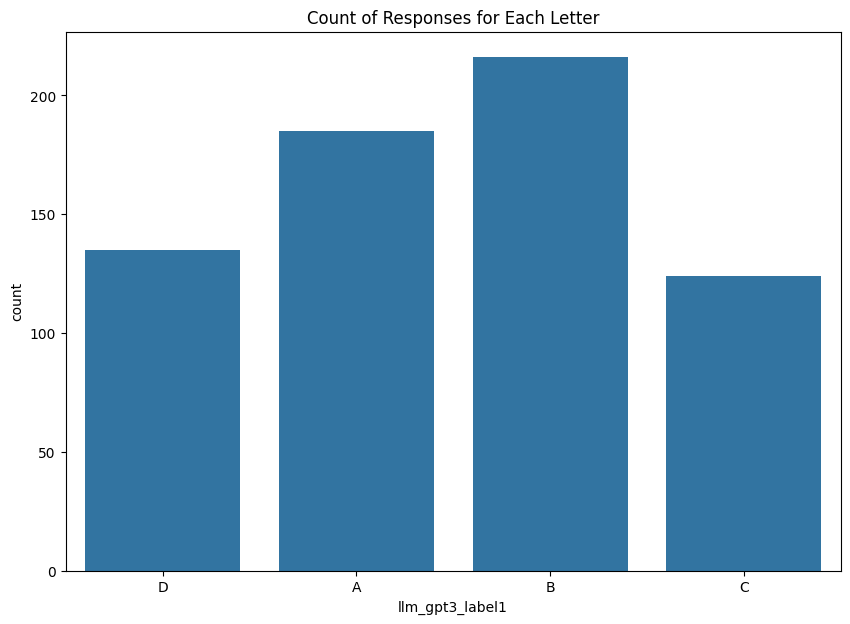

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.countplot(x='llm_gpt3_label1', data=df)
plt.title('Count of Responses for Each Letter')
plt.show()


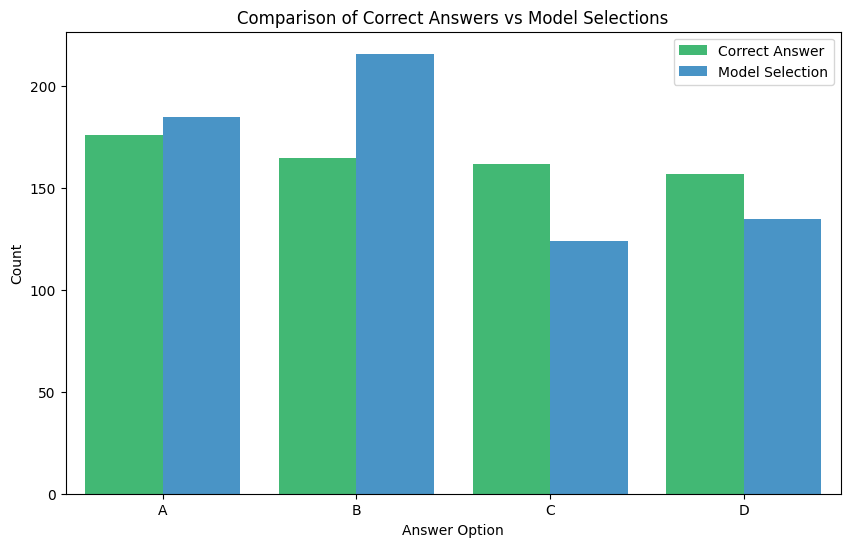

Counts:
  Answer  Correct Answer  Model Selection
0      A             176              185
1      B             165              216
2      C             162              124
3      D             157              135

Overall accuracy: 42.42%

Accuracy by answer option:
answer_idx_shuffled
A    0.426136
B    0.545455
C    0.364198
D    0.356688
dtype: float64


/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_18068/3408234048.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_option = df.groupby('answer_idx_shuffled').apply(lambda x: (x['answer_idx_shuffled'] == x['llm_gpt3_label1']).mean())


In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Capitalize df['answer_idx_shuffled']
df['answer_idx_shuffled'] = df['answer_idx_shuffled'].str.upper()

# Count the occurrences of each letter in answer_idx_shuffled and llm_gpt3_label1
correct_counts = df['answer_idx_shuffled'].value_counts()
model_counts = df['llm_gpt3_label1'].value_counts()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Correct Answer': correct_counts,
    'Model Selection': model_counts
})

# Fill any missing values with 0
plot_data = plot_data.fillna(0)

# Reset the index to make 'A', 'B', 'C', 'D' a column
plot_data = plot_data.reset_index()
plot_data.columns = ['Answer', 'Correct Answer', 'Model Selection']

# Melt the DataFrame for easier plotting
plot_data_melted = pd.melt(plot_data, id_vars=['Answer'], var_name='Type', value_name='Count')

# Define custom colors
color_dict = {
    'Correct Answer': '#2ecc71',  # Green color
    'Model Selection': '#3498db'  # Blue color (you can change this to any color you prefer)
}

# Create the seaborn histogram with custom colors
plt.figure(figsize=(10, 6))
sns.barplot(x='Answer', y='Count', hue='Type', data=plot_data_melted, palette=color_dict)
plt.title('Comparison of Correct Answers vs Model Selections')
plt.xlabel('Answer Option')
plt.ylabel('Count')

# Adjust legend
plt.legend(title='', loc='upper right')

plt.show()

# Print the counts for reference
print("Counts:")
print(plot_data)

# Calculate and print the accuracy for each answer option
accuracy = (df['answer_idx_shuffled'] == df['llm_gpt3_label1']).mean()
print(f"\nOverall accuracy: {accuracy:.2%}")

accuracy_by_option = df.groupby('answer_idx_shuffled').apply(lambda x: (x['answer_idx_shuffled'] == x['llm_gpt3_label1']).mean())
print("\nAccuracy by answer option:")
print(accuracy_by_option)


#### 1.3. Performance and Gender


Gender: male
Overall accuracy: 42.15%
Accuracy by answer option:
answer_idx_shuffled
A    0.440678
B    0.525424
C    0.358491
D    0.346154
dtype: float64

Gender: female
Overall accuracy: 42.01%
Accuracy by answer option:
answer_idx_shuffled
A    0.416667
B    0.547170
C    0.396226
D    0.320755
dtype: float64

Gender: neutral
Overall accuracy: 43.12%
Accuracy by answer option:
answer_idx_shuffled
A    0.421053
B    0.566038
C    0.339286
D    0.403846
dtype: float64


/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_18068/2949974746.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_option = gender_df.groupby('answer_idx_shuffled').apply(lambda x: (x['answer_idx_shuffled'] == x['llm_gpt3_label1']).mean())
/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_18068/2949974746.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_opt

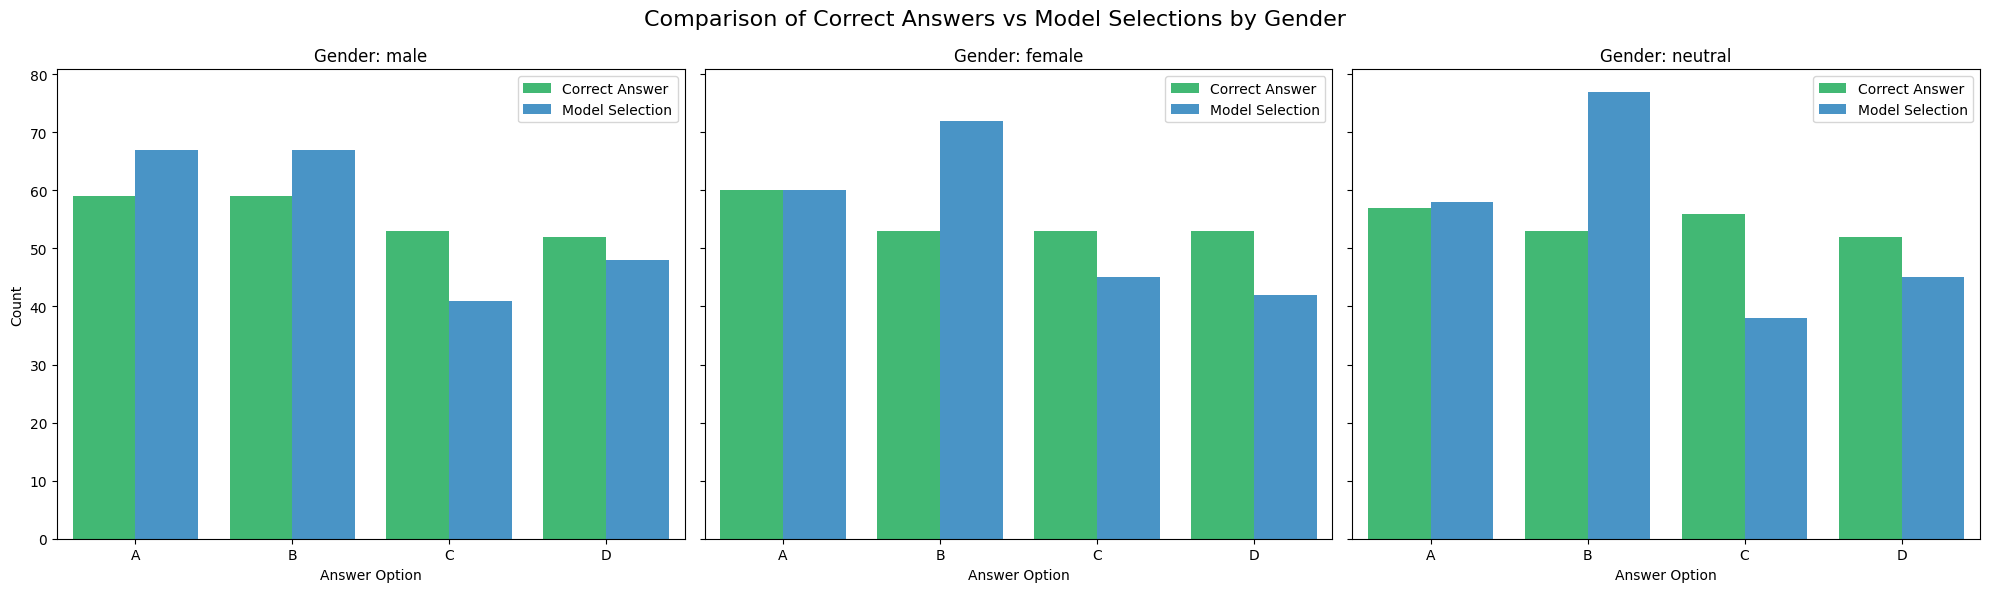

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Capitalize df['answer_idx_shuffled']
df['answer_idx_shuffled'] = df['answer_idx_shuffled'].str.upper()

# Define custom colors
color_dict = {
    'Correct Answer': '#2ecc71',  # Green color
    'Model Selection': '#3498db'  # Blue color (you can change this to any color you prefer)
}

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle('Comparison of Correct Answers vs Model Selections by Gender', fontsize=16)

# Loop through each gender
for i, gender in enumerate(df['gender'].unique()):
    # Filter data for the current gender
    gender_df = df[df['gender'] == gender]
    
    # Count the occurrences of each letter in answer_idx_shuffled and llm_gpt3_label1
    correct_counts = gender_df['answer_idx_shuffled'].value_counts()
    model_counts = gender_df['llm_gpt3_label1'].value_counts()

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Correct Answer': correct_counts,
        'Model Selection': model_counts
    })

    # Fill any missing values with 0 and ensure all options (A, B, C, D) are present
    plot_data = plot_data.reindex(['A', 'B', 'C', 'D']).fillna(0)

    # Reset the index to make 'A', 'B', 'C', 'D' a column
    plot_data = plot_data.reset_index()
    plot_data.columns = ['Answer', 'Correct Answer', 'Model Selection']

    # Melt the DataFrame for easier plotting
    plot_data_melted = pd.melt(plot_data, id_vars=['Answer'], var_name='Type', value_name='Count')

    # Create the seaborn histogram with custom colors
    sns.barplot(x='Answer', y='Count', hue='Type', data=plot_data_melted, palette=color_dict, ax=axes[i])
    axes[i].set_title(f'Gender: {gender}')
    axes[i].set_xlabel('Answer Option')
    if i == 0:  # Only set ylabel for the first subplot
        axes[i].set_ylabel('Count')
    else:
        axes[i].set_ylabel('')
    
    # Adjust legend
    axes[i].legend(title='', loc='upper right')
    
    # Calculate and print the accuracy for each answer option
    accuracy = (gender_df['answer_idx_shuffled'] == gender_df['llm_gpt3_label1']).mean()
    print(f"\nGender: {gender}")
    print(f"Overall accuracy: {accuracy:.2%}")
    
    accuracy_by_option = gender_df.groupby('answer_idx_shuffled').apply(lambda x: (x['answer_idx_shuffled'] == x['llm_gpt3_label1']).mean())
    print("Accuracy by answer option:")
    print(accuracy_by_option)

plt.tight_layout()
plt.show()


In [60]:
# Calculate and print accuracy by gender and overall
print("\nAccuracy by gender:")
for gender in df['gender'].unique():
    gender_df = df[df['gender'] == gender]
    gender_accuracy = (gender_df['answer_idx_shuffled'] == gender_df['llm_gpt3_label1']).mean()
    gender_count = len(gender_df)
    print(f"{gender}: {gender_accuracy:.2%} (n={gender_count})")

overall_accuracy = (df['answer_idx_shuffled'] == df['llm_gpt3_label1']).mean()
print(f"\nOverall accuracy across all genders: {overall_accuracy:.2%} (n={len(df)})")

# Calculate chi-square test for independence
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['gender'], df['answer_idx_shuffled'] == df['llm_gpt3_label1'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square test for independence:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print("Null hypothesis: There is no significant difference in accuracy across genders")
print(f"{'Reject' if p_value < 0.05 else 'Fail to reject'} the null hypothesis (α = 0.05)")



Accuracy by gender:
male: 42.15% (n=223)
female: 42.01% (n=219)
neutral: 43.12% (n=218)

Overall accuracy across all genders: 42.42% (n=660)

Chi-square test for independence:
Chi-square statistic: 0.0653
p-value: 0.9679
Null hypothesis: There is no significant difference in accuracy across genders
Fail to reject the null hypothesis (α = 0.05)


#### 1.4. Performance and version

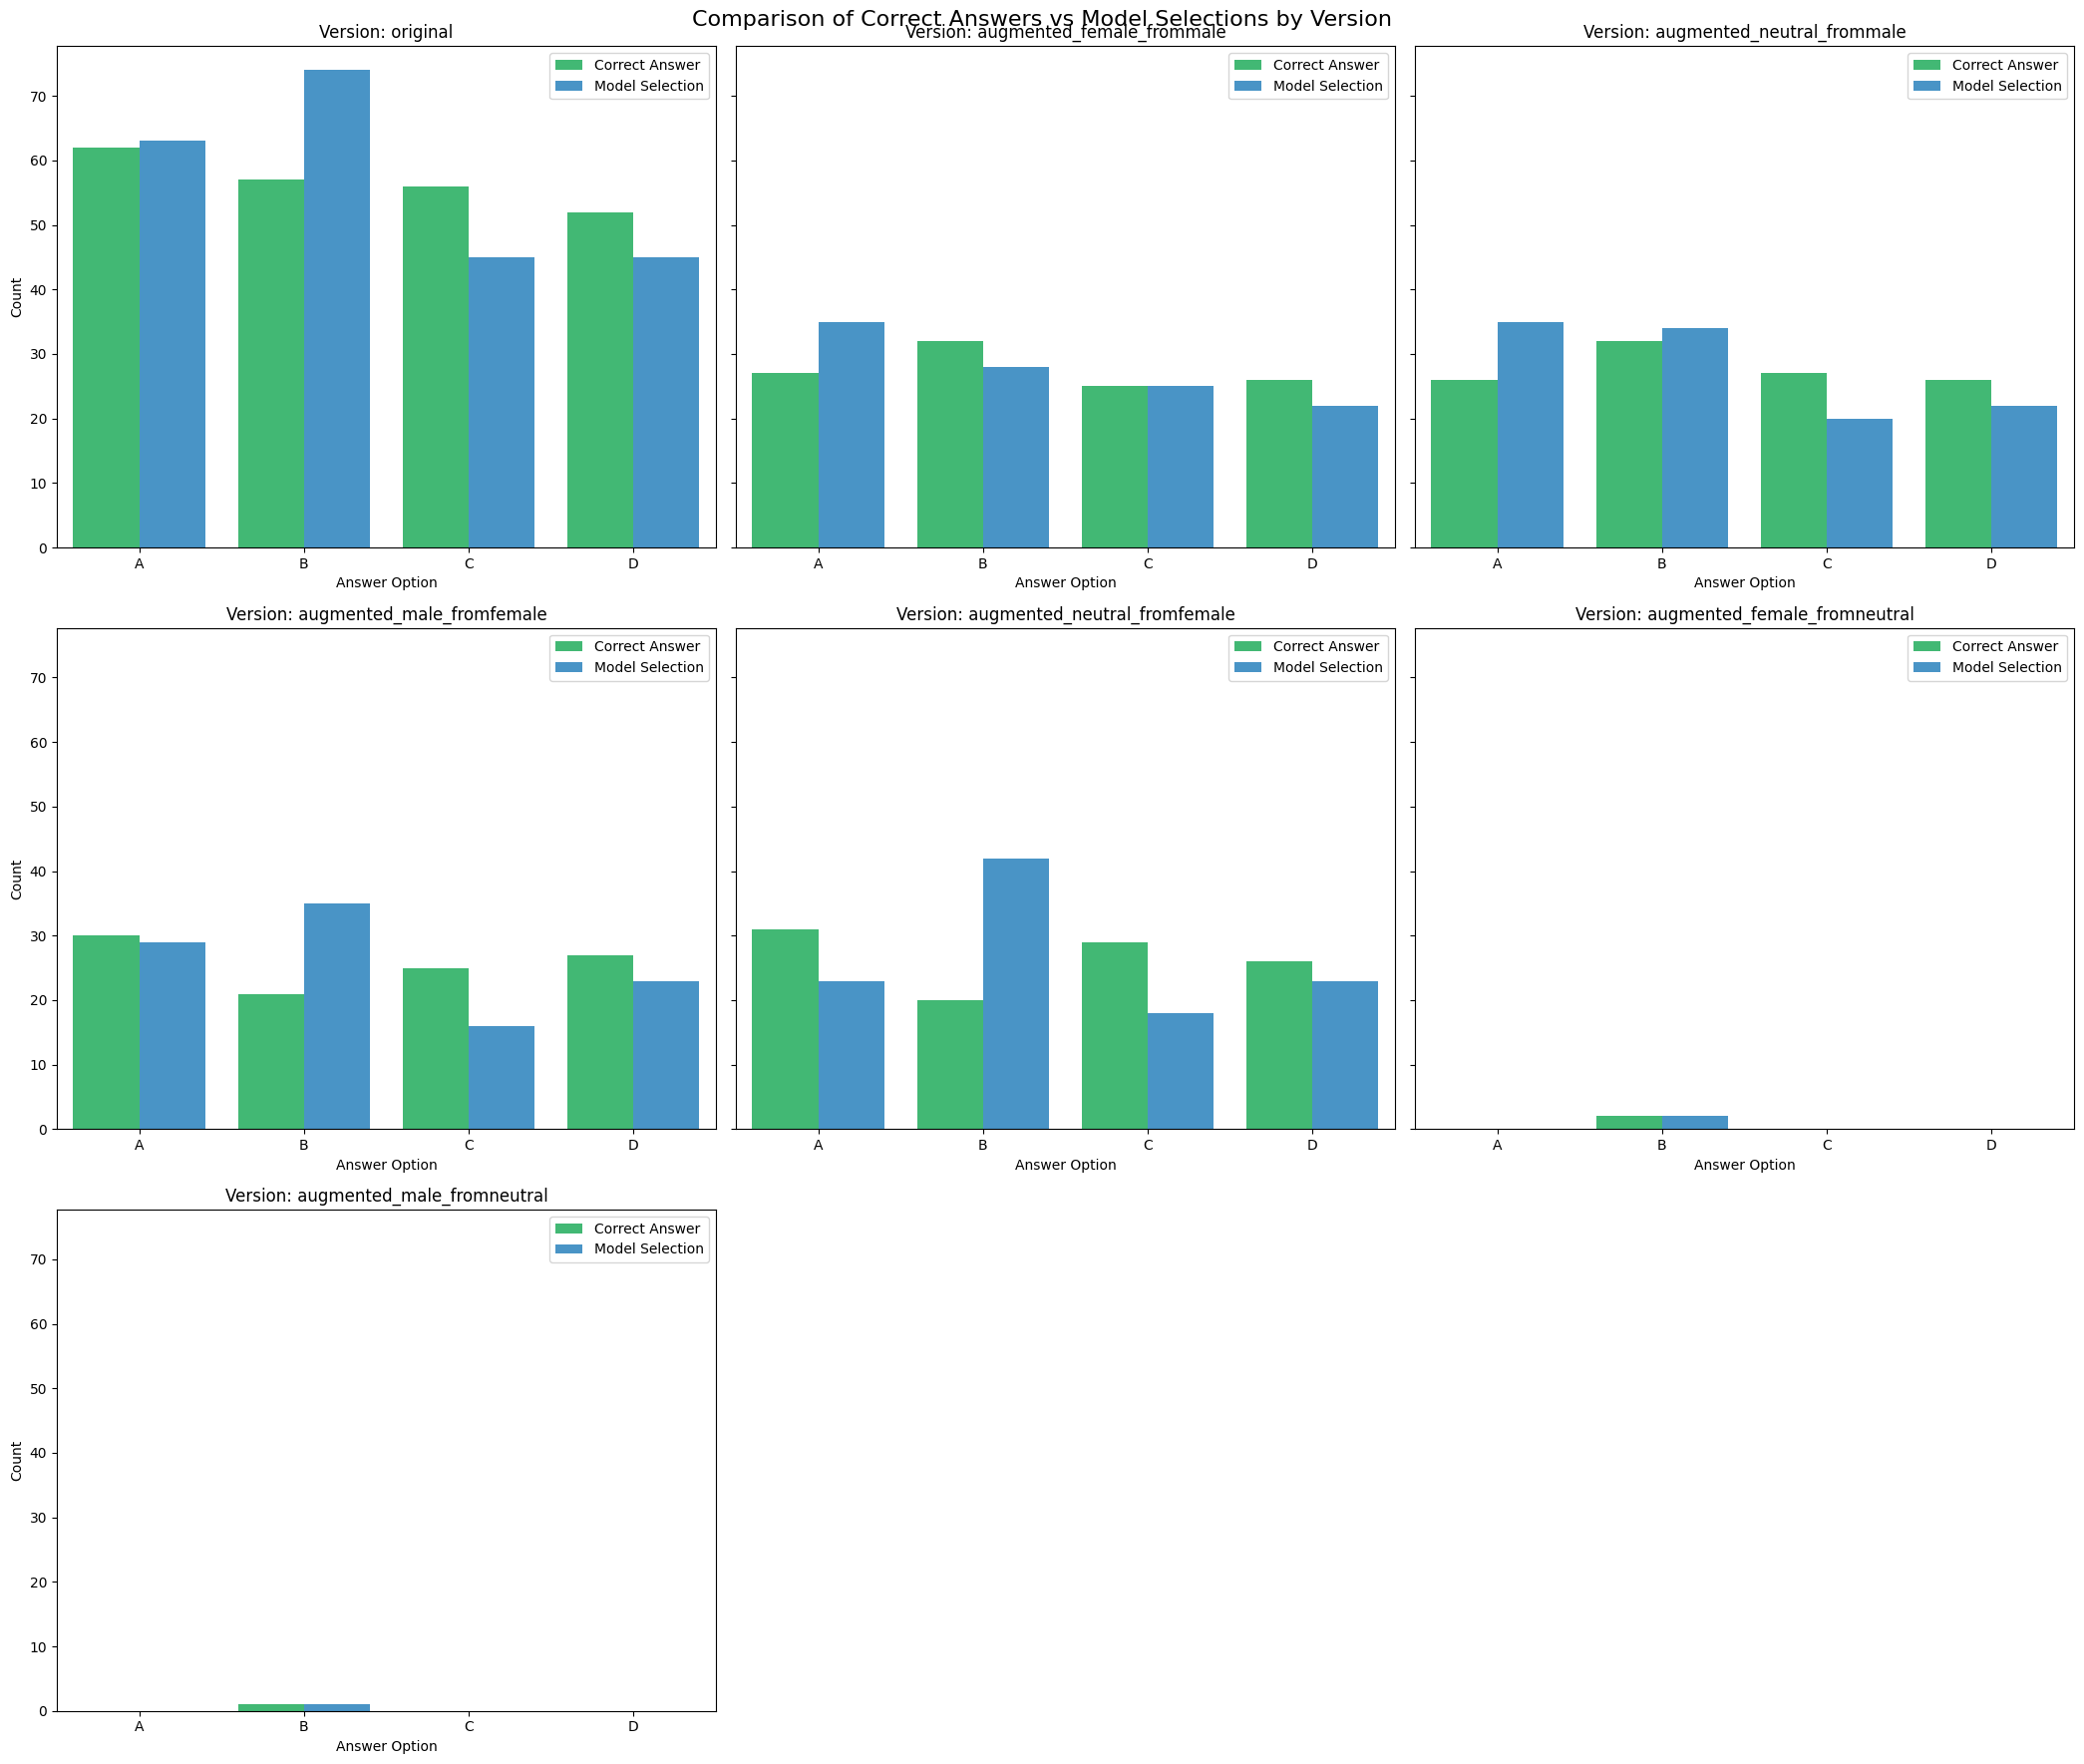


Accuracy by version:
original: 42.73% (n=227)
augmented_female_frommale: 47.27% (n=110)
augmented_neutral_frommale: 47.75% (n=111)
augmented_male_fromfemale: 33.98% (n=103)
augmented_neutral_fromfemale: 37.74% (n=106)
augmented_female_fromneutral: 100.00% (n=2)
augmented_male_fromneutral: 100.00% (n=1)

Overall accuracy across all versions: 42.42% (n=660)

Chi-square test for independence:
Chi-square statistic: 10.3870
p-value: 0.1093
Null hypothesis: There is no significant difference in accuracy across versions
Fail to reject the null hypothesis (α = 0.05)


In [61]:
# Capitalize df['answer_idx_shuffled']
df['answer_idx_shuffled'] = df['answer_idx_shuffled'].str.upper()

# Define custom colors
color_dict = {
    'Correct Answer': '#2ecc71',  # Green color
    'Model Selection': '#3498db'  # Blue color (you can change this to any color you prefer)
}

# Get unique versions and calculate the number of subplots needed
versions = df['version'].unique()
n_versions = len(versions)

# Create a figure with subplots (adjust the layout based on the number of versions)
n_cols = min(3, n_versions)  # Maximum 3 columns
n_rows = (n_versions - 1) // 3 + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 6*n_rows), sharey=True)
fig.suptitle('Comparison of Correct Answers vs Model Selections by Version', fontsize=16)

# Flatten axes array for easier indexing if there's only one row
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Loop through each version
for i, version in enumerate(versions):
    row = i // 3
    col = i % 3
    
    # Filter data for the current version
    version_df = df[df['version'] == version]
    
    # Count the occurrences of each letter in answer_idx_shuffled and llm_gpt3_label1
    correct_counts = version_df['answer_idx_shuffled'].value_counts()
    model_counts = version_df['llm_gpt3_label1'].value_counts()

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Correct Answer': correct_counts,
        'Model Selection': model_counts
    })

    # Fill any missing values with 0 and ensure all options (A, B, C, D) are present
    plot_data = plot_data.reindex(['A', 'B', 'C', 'D']).fillna(0)

    # Reset the index to make 'A', 'B', 'C', 'D' a column
    plot_data = plot_data.reset_index()
    plot_data.columns = ['Answer', 'Correct Answer', 'Model Selection']

    # Melt the DataFrame for easier plotting
    plot_data_melted = pd.melt(plot_data, id_vars=['Answer'], var_name='Type', value_name='Count')

    # Create the seaborn histogram with custom colors
    sns.barplot(x='Answer', y='Count', hue='Type', data=plot_data_melted, palette=color_dict, ax=axes[row, col])
    axes[row, col].set_title(f'Version: {version}')
    axes[row, col].set_xlabel('Answer Option')
    if col == 0:  # Only set ylabel for the first subplot in each row
        axes[row, col].set_ylabel('Count')
    else:
        axes[row, col].set_ylabel('')
    
    # Adjust legend
    axes[row, col].legend(title='', loc='upper right')

# Remove any unused subplots
for i in range(n_versions, n_rows * n_cols):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# Calculate and print accuracy by version and overall
print("\nAccuracy by version:")
for version in versions:
    version_df = df[df['version'] == version]
    version_accuracy = (version_df['answer_idx_shuffled'] == version_df['llm_gpt3_label1']).mean()
    version_count = len(version_df)
    print(f"{version}: {version_accuracy:.2%} (n={version_count})")

overall_accuracy = (df['answer_idx_shuffled'] == df['llm_gpt3_label1']).mean()
print(f"\nOverall accuracy across all versions: {overall_accuracy:.2%} (n={len(df)})")

# Calculate chi-square test for independence
contingency_table = pd.crosstab(df['version'], df['answer_idx_shuffled'] == df['llm_gpt3_label1'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square test for independence:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print("Null hypothesis: There is no significant difference in accuracy across versions")
print(f"{'Reject' if p_value < 0.05 else 'Fail to reject'} the null hypothesis (α = 0.05)")


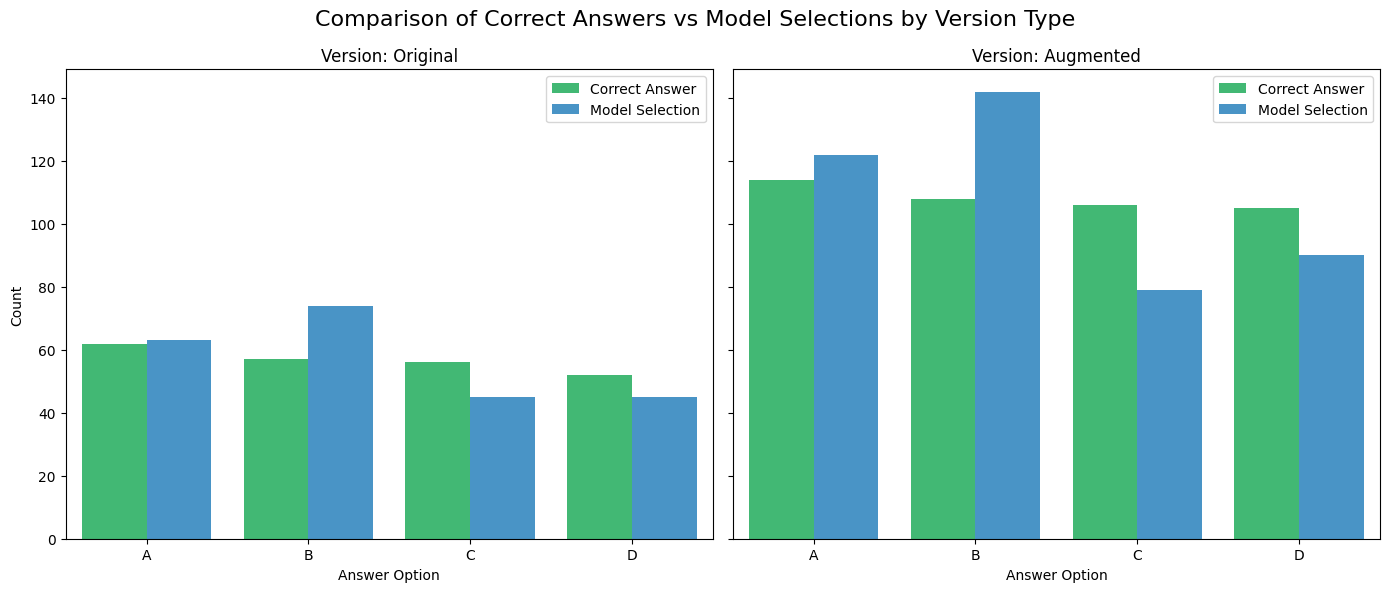


Accuracy by version type:
Original: 42.73% (n=227)
Augmented: 42.26% (n=433)

Overall accuracy across all versions: 42.42% (n=660)

Chi-square test for independence:
Chi-square statistic: 0.0011
p-value: 0.9739
Null hypothesis: There is no significant difference in accuracy between original and augmented versions
Fail to reject the null hypothesis (α = 0.05)


In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Create the binary version column
df['version_binary'] = df['version'].apply(lambda x: 'original' if x == 'original' else 'augmented')

# Capitalize df['answer_idx_shuffled']
df['answer_idx_shuffled'] = df['answer_idx_shuffled'].str.upper()

# Define custom colors
color_dict = {
    'Correct Answer': '#2ecc71',  # Green color
    'Model Selection': '#3498db'  # Blue color (you can change this to any color you prefer)
}

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle('Comparison of Correct Answers vs Model Selections by Version Type', fontsize=16)

# Loop through each binary version
for i, version in enumerate(['original', 'augmented']):
    # Filter data for the current version
    version_df = df[df['version_binary'] == version]
    
    # Count the occurrences of each letter in answer_idx_shuffled and llm_gpt3_label1
    correct_counts = version_df['answer_idx_shuffled'].value_counts()
    model_counts = version_df['llm_gpt3_label1'].value_counts()

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Correct Answer': correct_counts,
        'Model Selection': model_counts
    })

    # Fill any missing values with 0 and ensure all options (A, B, C, D) are present
    plot_data = plot_data.reindex(['A', 'B', 'C', 'D']).fillna(0)

    # Reset the index to make 'A', 'B', 'C', 'D' a column
    plot_data = plot_data.reset_index()
    plot_data.columns = ['Answer', 'Correct Answer', 'Model Selection']

    # Melt the DataFrame for easier plotting
    plot_data_melted = pd.melt(plot_data, id_vars=['Answer'], var_name='Type', value_name='Count')

    # Create the seaborn histogram with custom colors
    sns.barplot(x='Answer', y='Count', hue='Type', data=plot_data_melted, palette=color_dict, ax=axes[i])
    axes[i].set_title(f'Version: {version.capitalize()}')
    axes[i].set_xlabel('Answer Option')
    if i == 0:  # Only set ylabel for the first subplot
        axes[i].set_ylabel('Count')
    else:
        axes[i].set_ylabel('')
    
    # Adjust legend
    axes[i].legend(title='', loc='upper right')

plt.tight_layout()
plt.show()

# Calculate and print accuracy by binary version and overall
print("\nAccuracy by version type:")
for version in ['original', 'augmented']:
    version_df = df[df['version_binary'] == version]
    version_accuracy = (version_df['answer_idx_shuffled'] == version_df['llm_gpt3_label1']).mean()
    version_count = len(version_df)
    print(f"{version.capitalize()}: {version_accuracy:.2%} (n={version_count})")

overall_accuracy = (df['answer_idx_shuffled'] == df['llm_gpt3_label1']).mean()
print(f"\nOverall accuracy across all versions: {overall_accuracy:.2%} (n={len(df)})")

# Calculate chi-square test for independence
contingency_table = pd.crosstab(df['version_binary'], df['answer_idx_shuffled'] == df['llm_gpt3_label1'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square test for independence:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print("Null hypothesis: There is no significant difference in accuracy between original and augmented versions")
print(f"{'Reject' if p_value < 0.05 else 'Fail to reject'} the null hypothesis (α = 0.05)")


### 2. Gender specific question

In [52]:
# Before postprocessing
print("------ Before postprocessing ------")
print(f"Unique values of label2: {df['llm_gpt3_label2'].unique()}")


# Postprocessing
print("------ Postprocessing ------")

def extract_ranking(value):
    # Try to find a single digit at the start of the string
    match = re.match(r'^(\d)', str(value))
    if match:
        return int(match.group(1))
    
    # If not found, search for any single digit in the string
    match = re.search(r'\b(\d)\b', str(value))
    if match:
        return int(match.group(1))
    
    # If still not found, return None
    return None

def process_array(arr):
    return [extract_ranking(value) for value in arr]


df['llm_gpt3_label2'] = df['llm_gpt3_label2'].apply(extract_ranking)

# Human postprocessing
df.at[5, 'llm_gpt3_label2'] = 0
df.at[41, 'llm_gpt3_label2'] = 0


# Check for any remaining null values and print them for review
null_responses = df[df['llm_gpt3_label2'].isnull()]['llm_gpt3_response2']
if not null_responses.empty:
    print("Responses without extracted labels:")
    print(null_responses)
else:
    print("All responses have been assigned a label.")

# After postprocessing
print("------ Postprocessing ------")
print(f"Unique values of label2: {df['llm_gpt3_label2'].unique()}")



------ Before postprocessing ------
Unique values of label2: [ 2.  3.  0.  4.  1. nan  5.]
------ Postprocessing ------
Responses without extracted labels:
145    The relevance of the patient's gender in this ...
146    The relevance of the patient's gender in this ...
161    The relevance of gender in this clinical case ...
199    The relevance of the patient's gender in this ...
230    The relevance of gender in this clinical case ...
282    The relevance of the patient's gender in this ...
283    The relevance of the patient's gender in this ...
284    The relevance of the patient's gender in this ...
390    The relevance of gender in this clinical case ...
391    The relevance of gender in this clinical case ...
392    The relevance of the patient's gender in this ...
433    The relevance of gender in this clinical case ...
504    The relevance of the patient's gender in this ...
505    The relevance of gender in this clinical case ...
506    The relevance of gender in this clinica

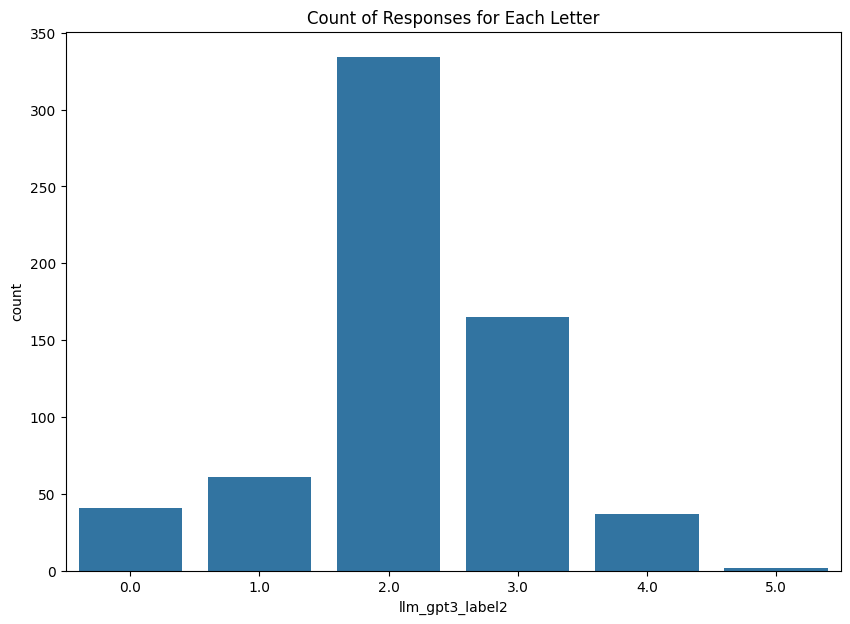

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.countplot(x='llm_gpt3_label2', data=df)
plt.title('Count of Responses for Each Letter')
plt.show()


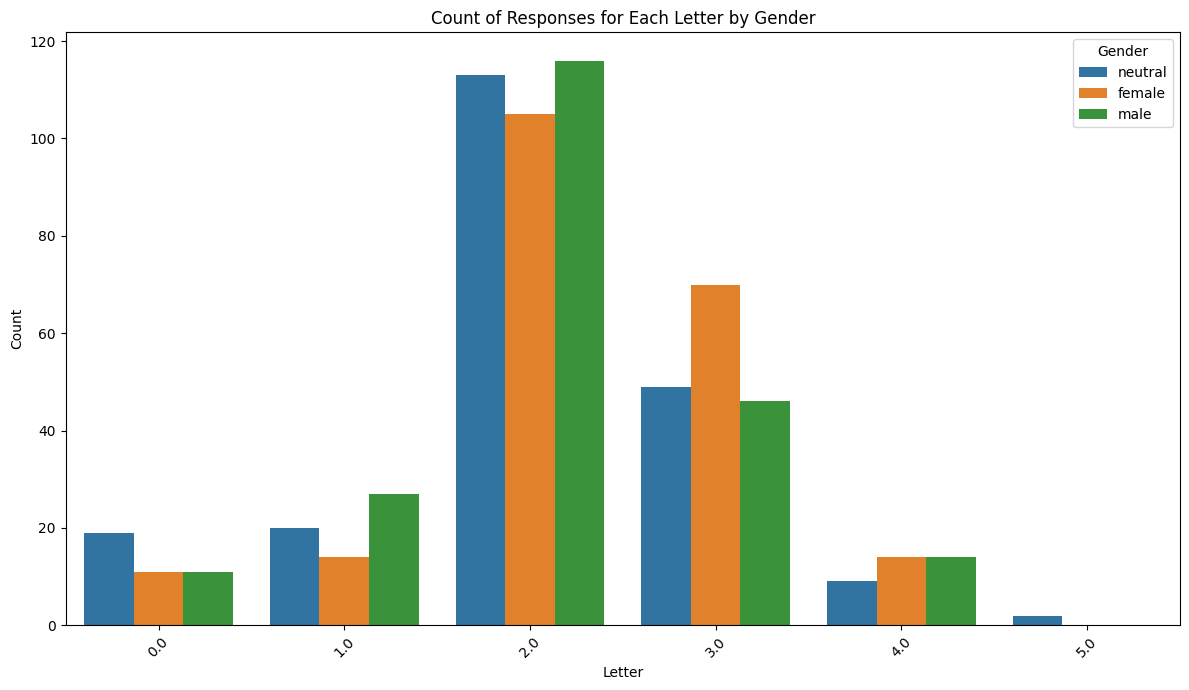

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.countplot(x='llm_gpt3_label2', hue='gender', data=df)
plt.title('Count of Responses for Each Letter by Gender')
plt.xlabel('Letter')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


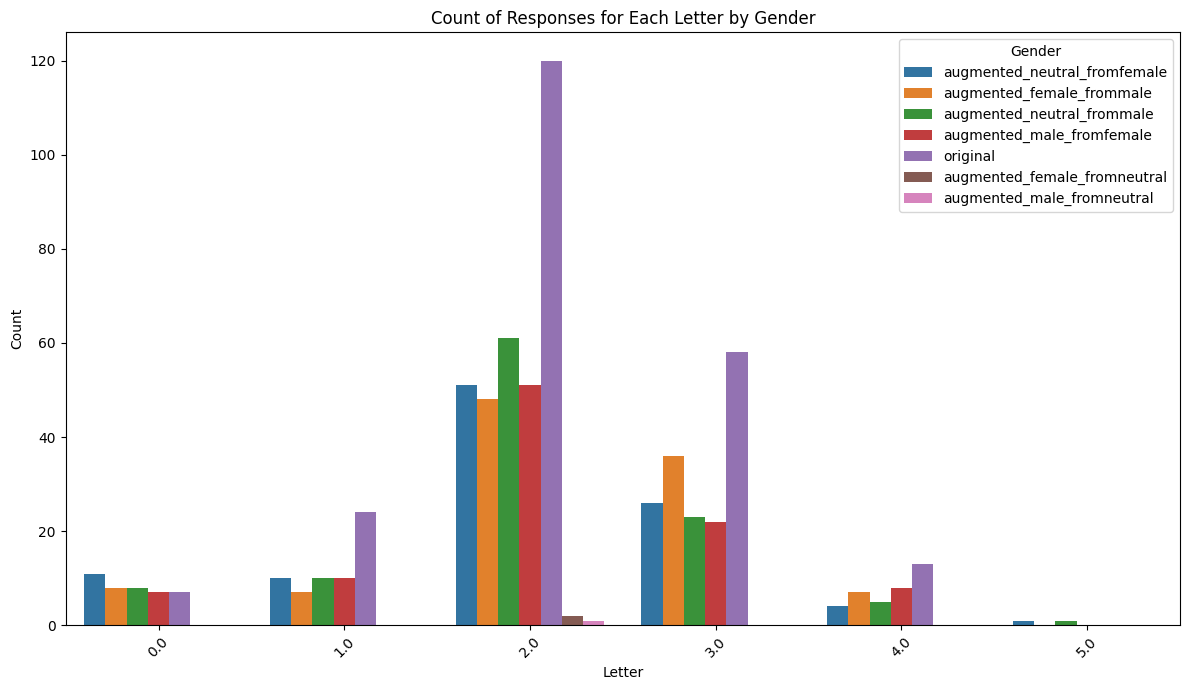

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.countplot(x='llm_gpt3_label2', hue='version', data=df)
plt.title('Count of Responses for Each Letter by Gender')
plt.xlabel('Letter')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# II. Performance analysis

### Accuracy and gender and version

Accuracy Table (Gender vs Version):
version_binary augmented original Average
gender                                   
female            48.21%   35.51%  41.86%
male              34.62%   48.74%  41.68%
neutral           42.86%  100.00%  71.43%
Average           41.90%   61.42%  51.66%


/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_18068/472002007.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_table = df.groupby(['gender', 'version_binary']).apply(calculate_accuracy).unstack()
/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_18068/472002007.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  accuracy_table_formatted = accuracy_table.applymap(lambda x: f"{x:.2%}")


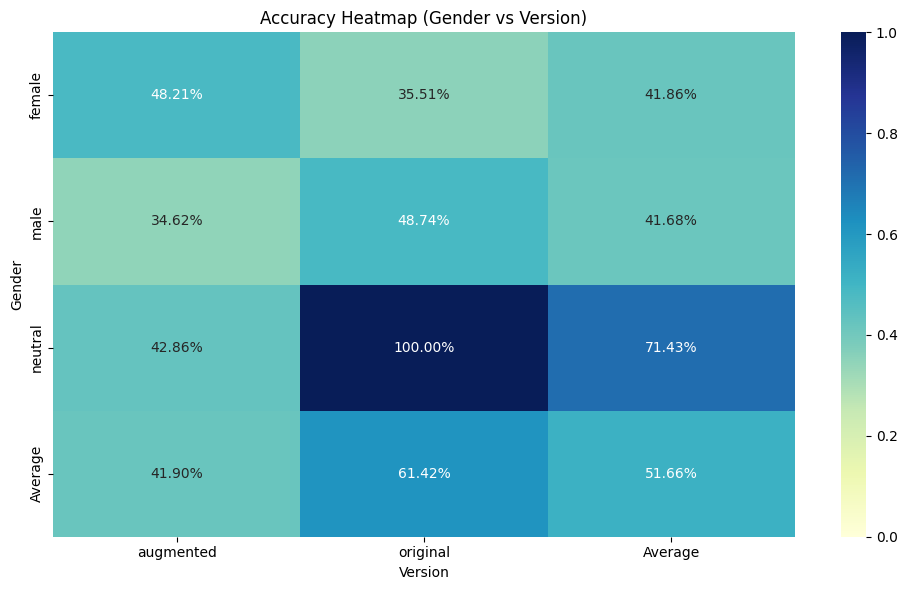


Chi-square test for independence:
Chi-square statistic: 9.5421
p-value: 0.0893
Null hypothesis: There is no significant difference in accuracy across gender-version combinations
Fail to reject the null hypothesis (α = 0.05)


In [66]:
# Function to calculate accuracy
def calculate_accuracy(group):
    return (group['answer_idx_shuffled'] == group['llm_gpt3_label1']).mean()

# Create a pivot table of accuracies
accuracy_table = df.groupby(['gender', 'version_binary']).apply(calculate_accuracy).unstack()

# Calculate row and column averages
accuracy_table['Average'] = accuracy_table.mean(axis=1)
accuracy_table.loc['Average'] = accuracy_table.mean()

# Format the table as percentages
accuracy_table_formatted = accuracy_table.applymap(lambda x: f"{x:.2%}")

# Print the formatted table
print("Accuracy Table (Gender vs Version):")
print(accuracy_table_formatted)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_table, annot=accuracy_table_formatted, fmt='', cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Accuracy Heatmap (Gender vs Version)')
plt.ylabel('Gender')
plt.xlabel('Version')
plt.tight_layout()
plt.show()

# Perform statistical tests
from scipy.stats import chi2_contingency

# Flatten the multi-index
df['gender_version'] = df['gender'] + '_' + df['version_binary']

# Create the contingency table
contingency_table = pd.crosstab(df['gender_version'], df['answer_idx_shuffled'] == df['llm_gpt3_label1'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square test for independence:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print("Null hypothesis: There is no significant difference in accuracy across gender-version combinations")
print(f"{'Reject' if p_value < 0.05 else 'Fail to reject'} the null hypothesis (α = 0.05)")

# If the overall chi-square test is significant, perform post-hoc pairwise comparisons
if p_value < 0.05:
    print("\nPost-hoc pairwise comparisons:")
    from itertools import combinations
    
    for combo in combinations(contingency_table.index, 2):
        sub_table = contingency_table.loc[list(combo)]
        chi2, p_value, dof, expected = chi2_contingency(sub_table)
        print(f"{combo[0]} vs {combo[1]}:")
        print(f"  Chi-square statistic: {chi2:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  {'Significant' if p_value < 0.05 else 'Not significant'} (α = 0.05)")
        print()


Accuracy Table (Gender vs Version):
version_binary original augmented Average
gender                                   
female           35.51%    48.21%  41.86%
male             48.74%    34.62%  41.68%
neutral         100.00%    42.86%  71.43%
Average          61.42%    41.90%  51.66%


/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_18068/3736260223.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_table = df.groupby(['gender', 'version_binary']).apply(calculate_accuracy).unstack()
/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_18068/3736260223.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  accuracy_table_formatted = accuracy_table.applymap(lambda x: f"{x:.2%}")


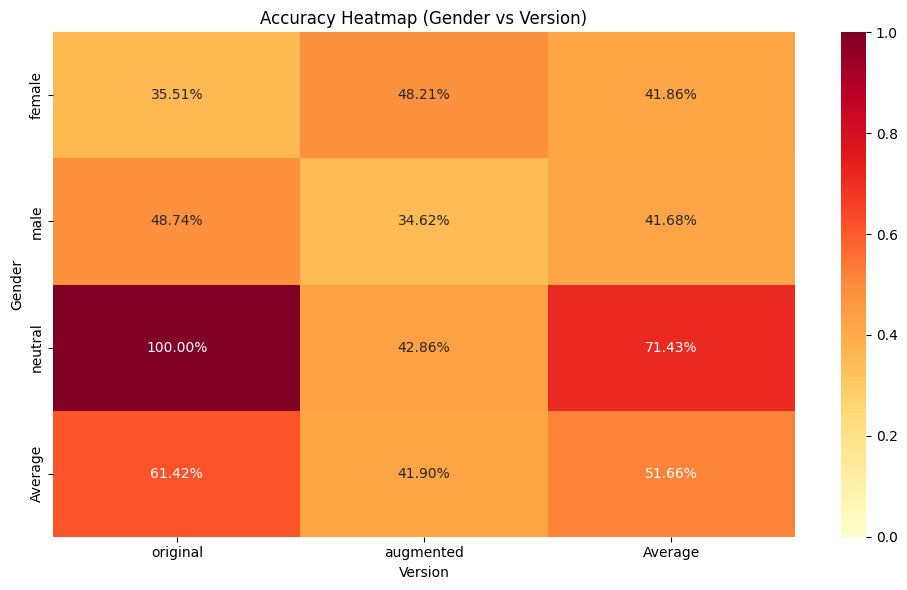


Chi-square test for independence:
Chi-square statistic: 9.5421
p-value: 0.0893
Null hypothesis: There is no significant difference in accuracy across gender-version combinations
Fail to reject the null hypothesis (α = 0.05)


In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate accuracy
def calculate_accuracy(group):
    return (group['answer_idx_shuffled'] == group['llm_gpt3_label1']).mean()

# Create a pivot table of accuracies
accuracy_table = df.groupby(['gender', 'version_binary']).apply(calculate_accuracy).unstack()

# Reorder columns to put 'original' first
accuracy_table = accuracy_table[['original', 'augmented']]

# Calculate row and column averages
accuracy_table['Average'] = accuracy_table.mean(axis=1)
accuracy_table.loc['Average'] = accuracy_table.mean()

# Format the table as percentages
accuracy_table_formatted = accuracy_table.applymap(lambda x: f"{x:.2%}")

# Print the formatted table
print("Accuracy Table (Gender vs Version):")
print(accuracy_table_formatted)

# Create a heatmap with a warm color palette
plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_table, annot=accuracy_table_formatted, fmt='', cmap='YlOrRd', vmin=0, vmax=1)
plt.title('Accuracy Heatmap (Gender vs Version)')
plt.ylabel('Gender')
plt.xlabel('Version')
plt.tight_layout()
plt.show()

# Perform statistical tests
from scipy.stats import chi2_contingency

# Flatten the multi-index
df['gender_version'] = df['gender'] + '_' + df['version_binary']

# Create the contingency table
contingency_table = pd.crosstab(df['gender_version'], df['answer_idx_shuffled'] == df['llm_gpt3_label1'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square test for independence:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print("Null hypothesis: There is no significant difference in accuracy across gender-version combinations")
print(f"{'Reject' if p_value < 0.05 else 'Fail to reject'} the null hypothesis (α = 0.05)")

# If the overall chi-square test is significant, perform post-hoc pairwise comparisons
if p_value < 0.05:
    print("\nPost-hoc pairwise comparisons:")
    from itertools import combinations
    
    for combo in combinations(contingency_table.index, 2):
        sub_table = contingency_table.loc[list(combo)]
        chi2, p_value, dof, expected = chi2_contingency(sub_table)
        print(f"{combo[0]} vs {combo[1]}:")
        print(f"  Chi-square statistic: {chi2:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  {'Significant' if p_value < 0.05 else 'Not significant'} (α = 0.05)")
        print()


Accuracy Table (Gender vs Version):
version original augmented_female_frommale augmented_female_fromneutral  \
gender                                                                    
female    35.51%                    47.27%                      100.00%   
male      48.74%                      nan%                         nan%   
neutral  100.00%                      nan%                         nan%   
Average   61.42%                    47.27%                      100.00%   

version augmented_male_fromfemale augmented_male_fromneutral  \
gender                                                         
female                       nan%                       nan%   
male                       33.98%                    100.00%   
neutral                      nan%                       nan%   
Average                    33.98%                    100.00%   

version augmented_neutral_fromfemale augmented_neutral_frommale Average  
gender                                                

/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_18068/2916144009.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_table = df.groupby(['gender', 'version']).apply(calculate_accuracy).unstack()
/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_18068/2916144009.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  accuracy_table_formatted = accuracy_table.applymap(lambda x: f"{x:.2%}")


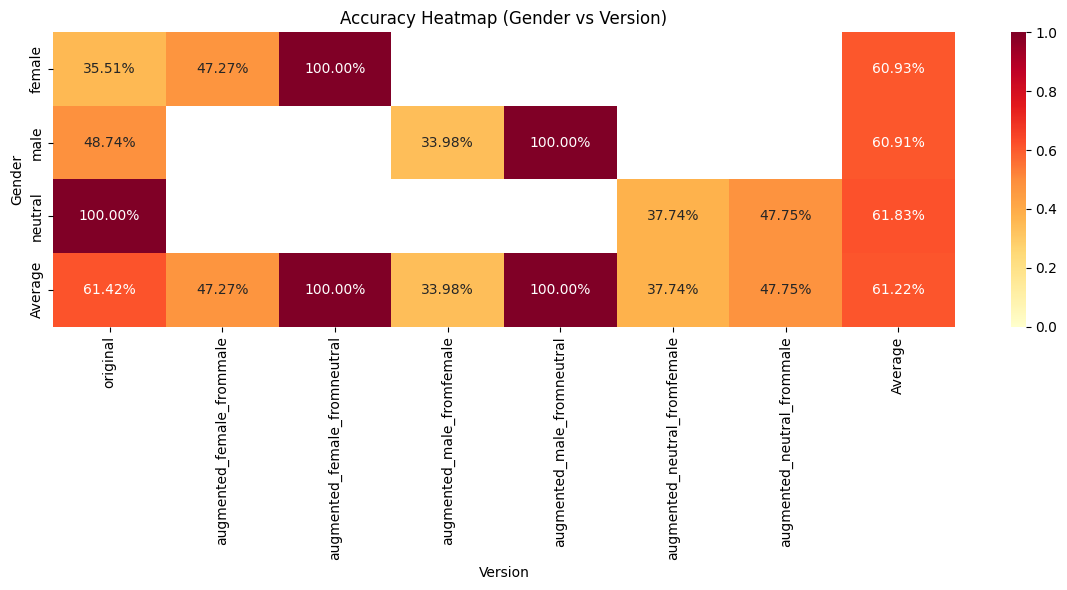


Chi-square test for independence:
Chi-square statistic: 15.7701
p-value: 0.0458
Null hypothesis: There is no significant difference in accuracy across gender-version combinations
Reject the null hypothesis (α = 0.05)

Post-hoc pairwise comparisons:
female_augmented_female_frommale vs female_augmented_female_fromneutral:
  Chi-square statistic: 0.5852
  p-value: 0.4443
  Not significant (α = 0.05)

female_augmented_female_frommale vs female_original:
  Chi-square statistic: 2.6242
  p-value: 0.1052
  Not significant (α = 0.05)

female_augmented_female_frommale vs male_augmented_male_fromfemale:
  Chi-square statistic: 3.3590
  p-value: 0.0668
  Not significant (α = 0.05)

female_augmented_female_frommale vs male_augmented_male_fromneutral:
  Chi-square statistic: 0.0021
  p-value: 0.9639
  Not significant (α = 0.05)

female_augmented_female_frommale vs male_original:
  Chi-square statistic: 0.0080
  p-value: 0.9286
  Not significant (α = 0.05)

female_augmented_female_frommale vs neutr

ValueError: The internally computed table of expected frequencies has a zero element at (0, 0).

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate accuracy
def calculate_accuracy(group):
    return (group['answer_idx_shuffled'] == group['llm_gpt3_label1']).mean()

# Create a pivot table of accuracies
accuracy_table = df.groupby(['gender', 'version']).apply(calculate_accuracy).unstack()

# Ensure 'original' is the first column if it exists
if 'original' in accuracy_table.columns:
    cols = ['original'] + [col for col in accuracy_table.columns if col != 'original']
    accuracy_table = accuracy_table[cols]

# Calculate row and column averages
accuracy_table['Average'] = accuracy_table.mean(axis=1)
accuracy_table.loc['Average'] = accuracy_table.mean()

# Format the table as percentages
accuracy_table_formatted = accuracy_table.applymap(lambda x: f"{x:.2%}")

# Print the formatted table
print("Accuracy Table (Gender vs Version):")
print(accuracy_table_formatted)

# Create a heatmap with a warm color palette
plt.figure(figsize=(12, 6))  # Increased width to accommodate more columns
sns.heatmap(accuracy_table, annot=accuracy_table_formatted, fmt='', cmap='YlOrRd', vmin=0, vmax=1)
plt.title('Accuracy Heatmap (Gender vs Version)')
plt.ylabel('Gender')
plt.xlabel('Version')
plt.tight_layout()
plt.show()

# Perform statistical tests
from scipy.stats import chi2_contingency

# Flatten the multi-index
df['gender_version'] = df['gender'] + '_' + df['version']

# Create the contingency table
contingency_table = pd.crosstab(df['gender_version'], df['answer_idx_shuffled'] == df['llm_gpt3_label1'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square test for independence:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print("Null hypothesis: There is no significant difference in accuracy across gender-version combinations")
print(f"{'Reject' if p_value < 0.05 else 'Fail to reject'} the null hypothesis (α = 0.05)")

# If the overall chi-square test is significant, perform post-hoc pairwise comparisons
if p_value < 0.05:
    print("\nPost-hoc pairwise comparisons:")
    from itertools import combinations
    
    for combo in combinations(contingency_table.index, 2):
        sub_table = contingency_table.loc[list(combo)]
        chi2, p_value, dof, expected = chi2_contingency(sub_table)
        print(f"{combo[0]} vs {combo[1]}:")
        print(f"  Chi-square statistic: {chi2:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  {'Significant' if p_value < 0.05 else 'Not significant'} (α = 0.05)")
        print()


### Accuracy per gender

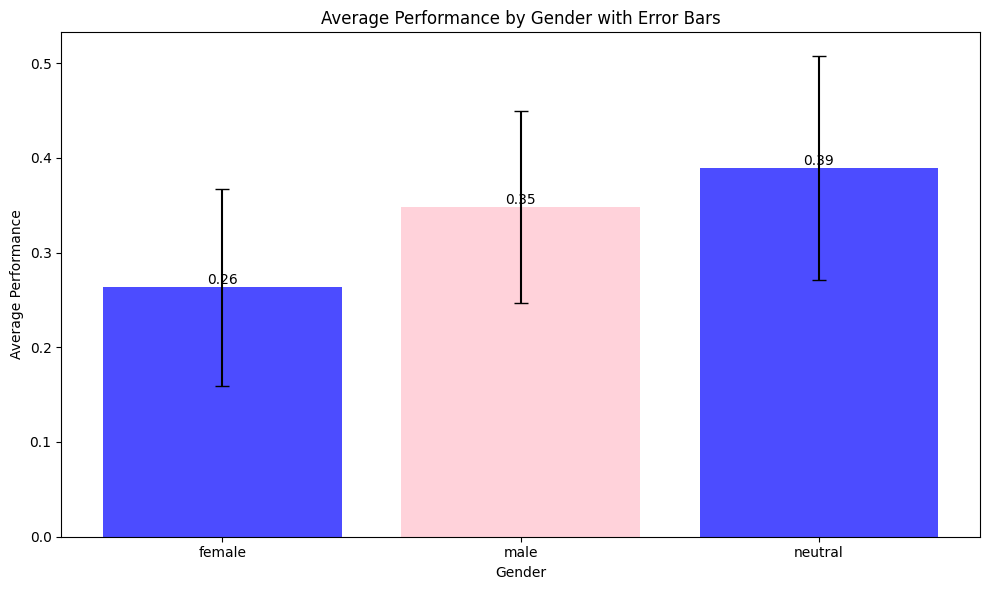

In [ ]:
# ========= PERFORMANCE PER GENDER =========
# Calculate the average performance and standard error for each gender
performance_by_gender = df.groupby('gender')['llm_gpt3_performance'].agg(['mean', 'sem'])

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
bars = ax.bar(performance_by_gender.index, performance_by_gender['mean'], 
              color=['blue', 'pink'], alpha=0.7)

# Add error bars
ax.errorbar(performance_by_gender.index, performance_by_gender['mean'], 
            yerr=performance_by_gender['sem'], fmt='none', color='black', capsize=5)

# Set plot title and labels
ax.set_title('Average Performance by Gender with Error Bars')
ax.set_xlabel('Gender')
ax.set_ylabel('Average Performance')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


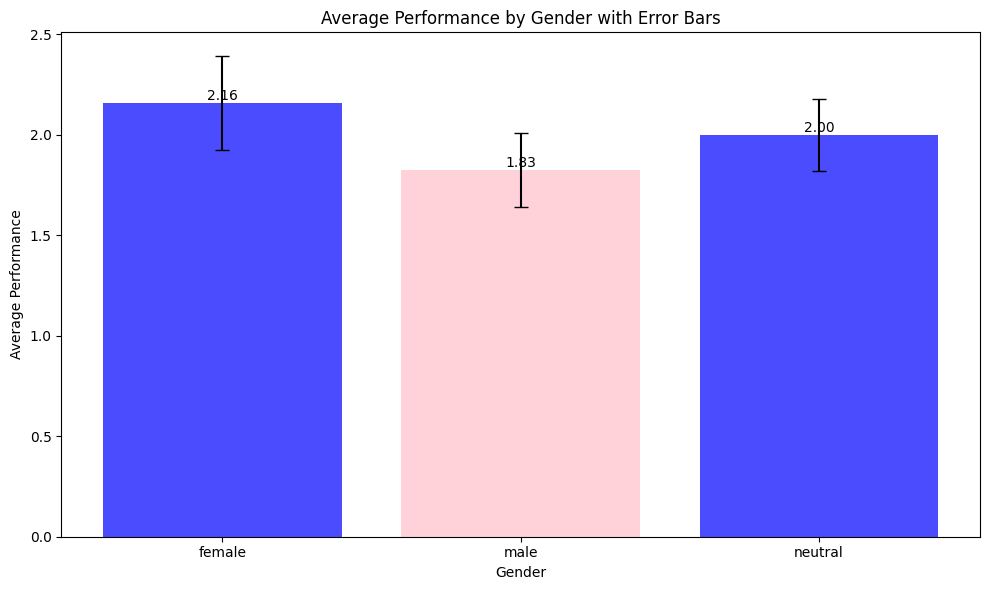

In [ ]:
# ========= GENDER IMPORTANCE =========

# Calculate the average performance and standard error for each gender
gender_importance = df.groupby('gender')['llm_gpt3_label2'].agg(['mean', 'sem'])

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
bars = ax.bar(gender_importance.index, gender_importance['mean'], 
              color=['blue', 'pink'], alpha=0.7)

# Add error bars
ax.errorbar(gender_importance.index, gender_importance['mean'], 
            yerr=gender_importance['sem'], fmt='none', color='black', capsize=5)

# Set plot title and labels
ax.set_title('Average Performance by Gender with Error Bars')
ax.set_xlabel('Gender')
ax.set_ylabel('Average Performance')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Explanations

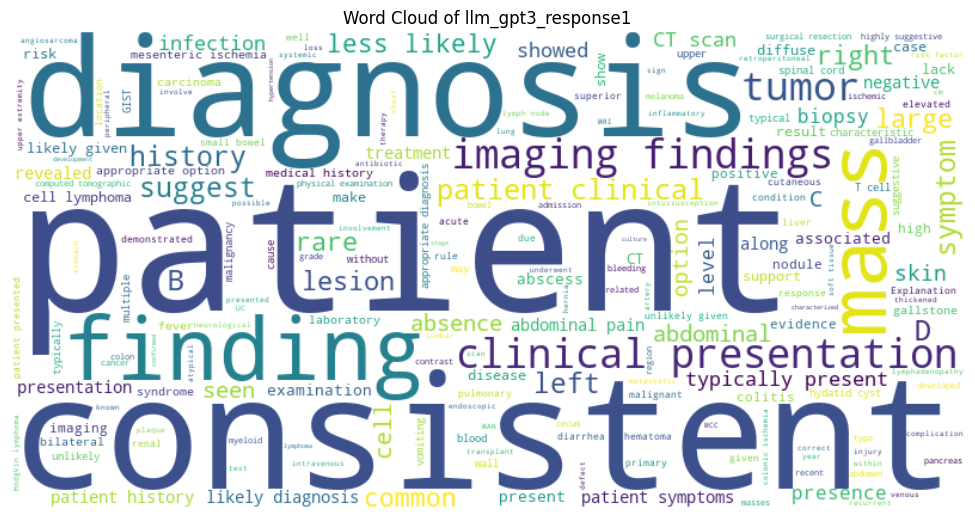

In [ ]:
# ===== PERFORMANCE EXPlANATION =====

# Combine all text from the column into a single string
text = ' '.join(df['llm_gpt3_response1'].dropna().astype(str))

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of llm_gpt3_response1')
plt.tight_layout(pad=0)


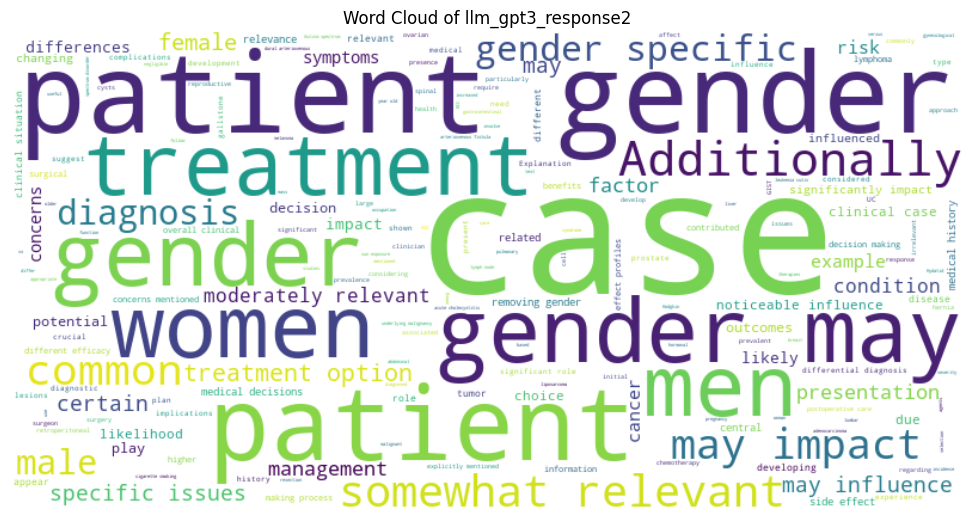

In [ ]:
# ===== GENDER CARE EXPlANATION =====

# Combine all text from the column into a single string
text = ' '.join(df['llm_gpt3_response2'].dropna().astype(str))

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of llm_gpt3_response2')
plt.tight_layout(pad=0)


# Metadata

In [ ]:
df.columns


Index(['link', 'question', 'opa', 'opb', 'opc', 'opd', 'diagnosis',
       'answer_idx', 'answer', 'explanation', 'field', 'case',
       'clinical_question', 'normalized_question', 'opa_shuffled',
       'opb_shuffled', 'opc_shuffled', 'opd_shuffled', 'answer_idx_shuffled',
       'test_image', 'test_lab', 'test_other', 'figure', 'gender', 'pregnancy',
       'woman_health', 'age', 'age_group', 'ethnicity', 'case_id', 'version',
       'llm_gpt3_response', 'llm_gpt3_time', 'llm_gpt3_prompt1',
       'llm_gpt3_prompt2', 'llm_gpt3_response1', 'llm_gpt3_response2',
       'llm_gpt3_chat_history', 'llm_gpt3_finish_reason_1',
       'llm_gpt3_prompt_tokens_1', 'llm_gpt3_completion_tokens_1',
       'llm_gpt3_finish_reason_2', 'llm_gpt3_prompt_tokens_2',
       'llm_gpt3_completion_tokens_2', 'llm_gpt3_input_price_1',
       'llm_gpt3_output_price_1', 'llm_gpt3_input_price_2',
       'llm_gpt3_output_price_2', 'llm_gpt3_total_price', 'llm_gpt3_label1',
       'llm_gpt3_explanation1', 'llm_g

                              count         mean         std         min  \
test_image                     60.0     0.716667    0.454420    0.000000   
test_lab                       60.0     0.800000    0.403376    0.000000   
test_other                     60.0     0.533333    0.503098    0.000000   
figure                         60.0     0.966667    0.181020    0.000000   
pregnancy                      60.0     0.000000    0.000000    0.000000   
woman_health                   60.0     0.000000    0.000000    0.000000   
age                            60.0    51.466667   22.246285    2.000000   
case_id                        60.0   954.866667  431.592065   28.000000   
llm_gpt3_response               0.0          NaN         NaN         NaN   
llm_gpt3_time                  60.0     0.000000    0.000000    0.000000   
llm_gpt3_prompt_tokens_1       60.0   641.466667  131.377508  385.000000   
llm_gpt3_completion_tokens_1   60.0   182.450000   31.839867  126.000000   
llm_gpt3_pro

/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_82899/1395914910.py:14: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  dataframe[numerical_col].hist(bins=20, ax=ax[0])


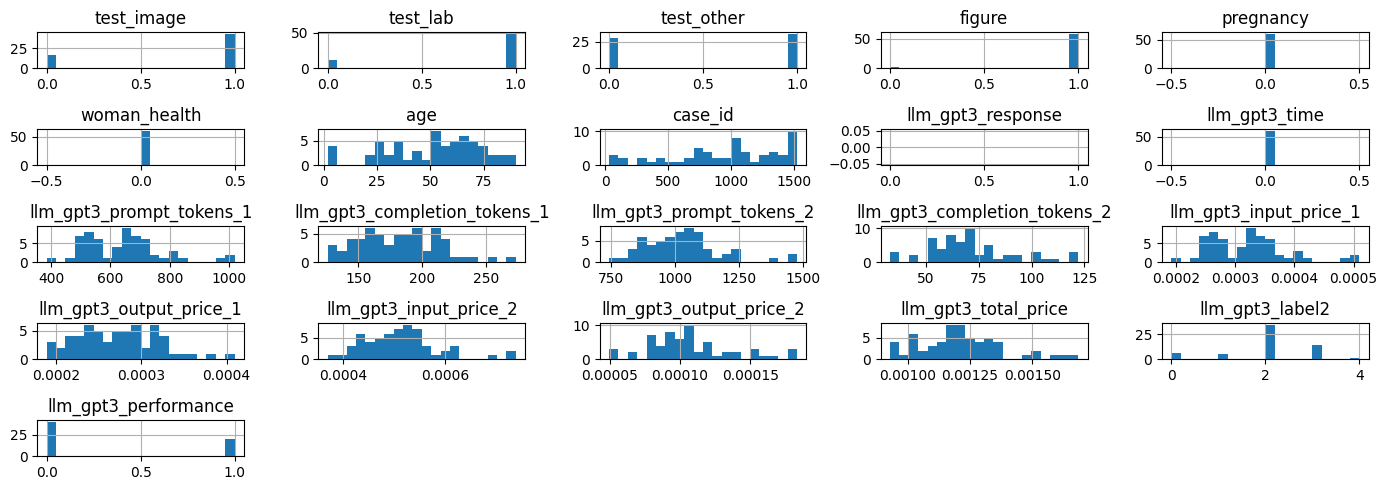

In [ ]:
num_cols = [col for col in df.columns if df[col].dtypes != "O"]

import matplotlib.pyplot as plt


def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        fig, ax = plt.subplots(
            1, 2, figsize=(14, 5)
        )  # 1 row, 2 columns for two subplots
        dataframe[numerical_col].hist(bins=20, ax=ax[0])
        ax[0].set_xlabel(numerical_col)
        ax[0].set_title(numerical_col)

        # Add more plots as needed

        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()


# Assuming df and num_cols are defined somewhere before calling num_summary
num_summary(df, num_cols, plot=True)



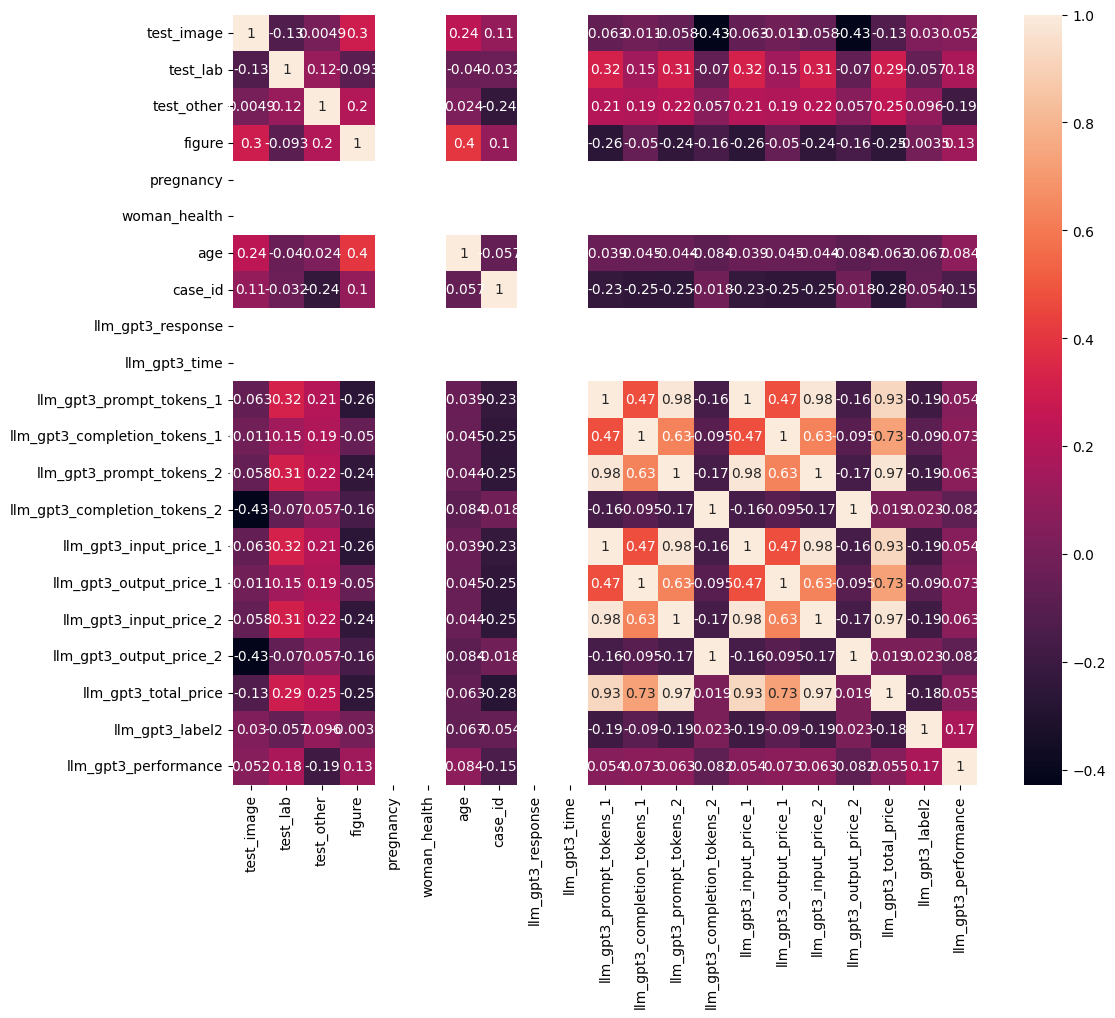

In [ ]:

plt.figure(figsize=(12, 10))
sns.heatmap(df[num_cols].corr(), annot=True)
plt.show()


ValueError: num must be an integer with 1 <= num <= 9, not 10

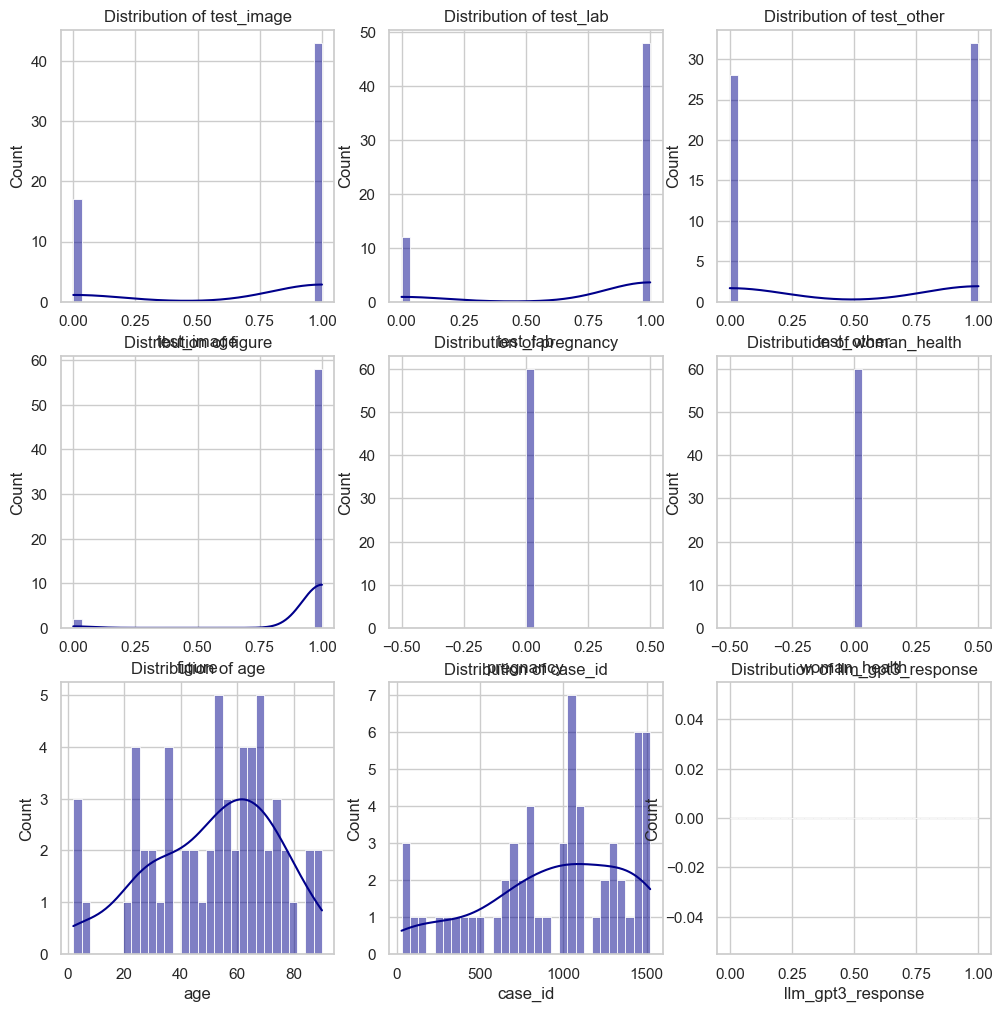

In [ ]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=df[col], color="darkblue", kde=True, bins=30)
    plt.title(f"Distribution of {col}")

# removing empty subplots
num_columns = len(num_cols)
num_rows = num_columns // 3 + (1 if num_columns % 3 != 0 else 0)
for i in range(num_columns, num_rows * 3):
    fig.delaxes(axes.flatten()[i])

fig.suptitle("Numerical Univariate Variable Analysis", fontsize=20, y=1.02)
plt.subplots_adjust(top=1.88)
plt.tight_layout()
plt.show()


In [ ]:
df.columns


Index(['link', 'question', 'opa', 'opb', 'opc', 'opd', 'diagnosis',
       'answer_idx', 'answer', 'explanation', 'field', 'case',
       'clinical_question', 'normalized_question', 'opa_shuffled',
       'opb_shuffled', 'opc_shuffled', 'opd_shuffled', 'answer_idx_shuffled',
       'test_image', 'test_lab', 'test_other', 'figure', 'gender', 'pregnancy',
       'woman_health', 'age', 'age_group', 'ethnicity', 'case_id', 'version',
       'llm_gpt3_response', 'llm_gpt3_time', 'llm_gpt3_prompt1',
       'llm_gpt3_prompt2', 'llm_gpt3_response1', 'llm_gpt3_response2',
       'llm_gpt3_chat_history', 'llm_gpt3_finish_reason_1',
       'llm_gpt3_prompt_tokens_1', 'llm_gpt3_completion_tokens_1',
       'llm_gpt3_finish_reason_2', 'llm_gpt3_prompt_tokens_2',
       'llm_gpt3_completion_tokens_2', 'llm_gpt3_input_price_1',
       'llm_gpt3_output_price_1', 'llm_gpt3_input_price_2',
       'llm_gpt3_output_price_2', 'llm_gpt3_total_price', 'llm_gpt3_label1',
       'llm_gpt3_explanation1', 'llm_g

In [ ]:
df['llm_gpt3_performance'].unique()


array([0., 1.])

/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_82899/749007480.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, hue="llm_gpt3_performance", fill=True, x=col, legend=False, ax=ax)
/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_82899/749007480.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, hue="llm_gpt3_performance", fill=True, x=col, legend=False, ax=ax)
/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_82899/749007480.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, hue="llm_gpt3_performance", fill=True, x=col, legend=False, ax=ax)
/var/folders/s2/jdv7kxv13hgf_3qqk7bg5p3r0000gn/T/ipykernel_82899/749007480.py:21: UserWarning: Dataset has 0 variance; skipping density 

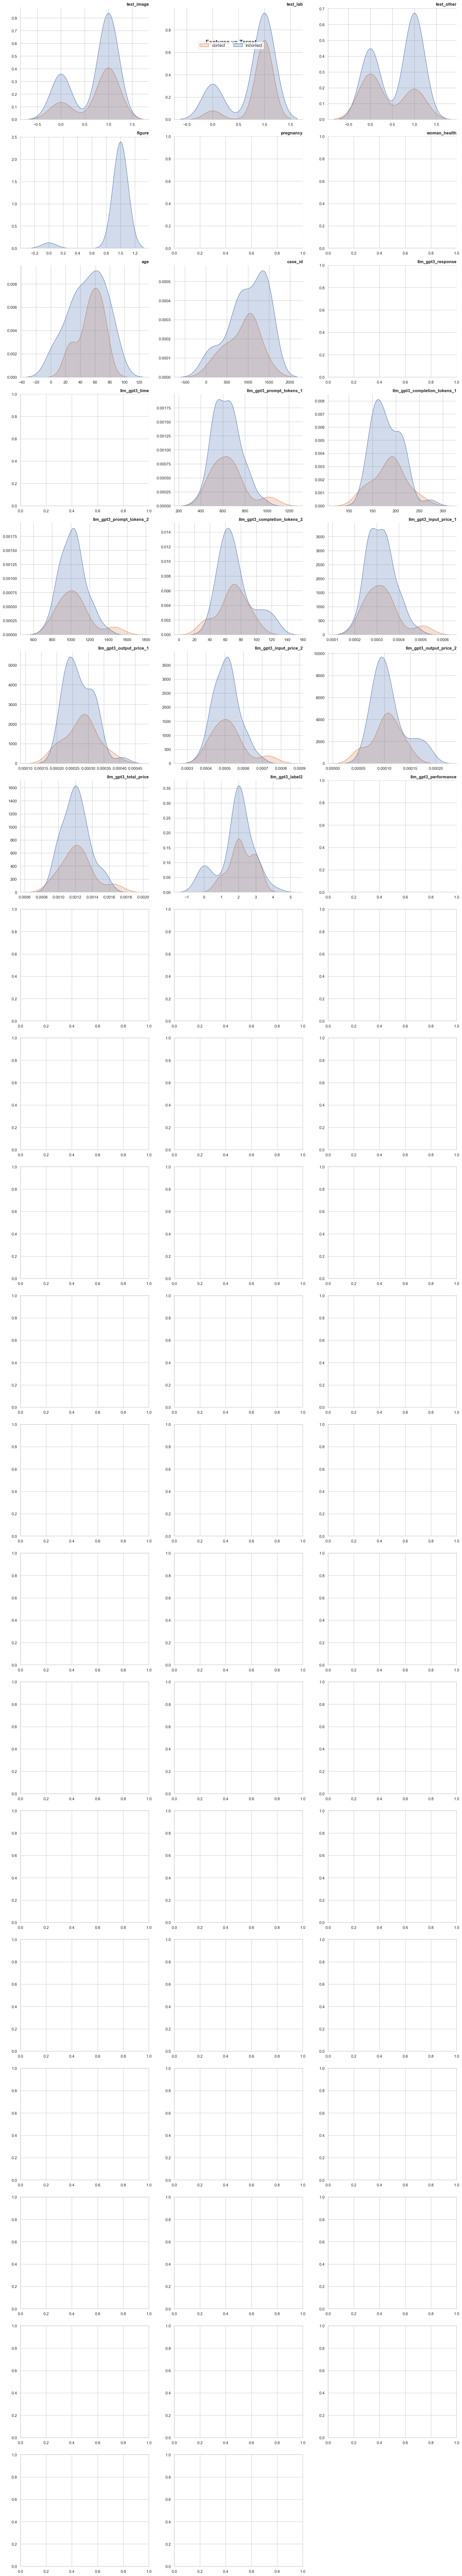

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Assuming df and num_cols are already defined

# Calculate the number of rows and columns needed
n_features = len(df[num_cols]) - 1
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Set up the figure size
figsize = (6 * n_cols, 5 * n_rows)
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

# Flatten the axes array for easier indexing
axes = axes.flatten()

for idx, col in enumerate(df[num_cols][:-1]):
    ax = axes[idx]
    sns.kdeplot(data=df, hue="llm_gpt3_performance", fill=True, x=col, legend=False, ax=ax)
    
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("")
    ax.set_title(f"{col}", loc="right", weight="bold", fontsize=12)

# Remove any unused subplots
for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

fig.suptitle(f"Features vs Target", ha="center", fontweight="bold", fontsize=16)
fig.legend(
    ["correct", "incorrect"],
    loc="upper center",
    bbox_to_anchor=(0.5, 0.98),
    fontsize=12,
    ncol=2,
)

plt.tight_layout()
plt.show()


# Useful

to modify to keep the latest saved in each folder

In [ ]:
import os
# import pandas as pd
# import glob

# # Set the root directory path
# root_directory = '/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/bias_llm_clinical_challenge/results/'

# # Get all CSV files starting with 'results' in alphabetical order, including subdirectories
# csv_files = sorted(glob.glob(os.path.join(root_directory, '**/results*.csv'), recursive=True))

# # Initialize an empty list to store DataFrames
# dfs = []

# # Initialize a set to store unique column names
# all_columns = set()

# # Dictionary to store duplicate case counts
# duplicate_cases = {}

# # Read each CSV file
# for file in csv_files:
#     df = pd.read_csv(file)
    
#     # Check for duplicate cases
#     duplicate_count = df['case'].duplicated().sum()
#     if duplicate_count > 0:
#         duplicate_cases[file] = duplicate_count
    
#     # Add columns to the set of all columns
#     all_columns.update(df.columns)
    
#     dfs.append(df)

# # Join all DataFrames
# joined_df = pd.concat(dfs, ignore_index=True)

# # Check for differences in columns
# different_columns = {}
# for file, df in zip(csv_files, dfs):
#     diff = set(all_columns) - set(df.columns)
#     if diff:
#         different_columns[file] = list(diff)

# # Print results
# print("Joined DataFrame shape:", joined_df.shape)

# if duplicate_cases:
#     print("\nFiles with duplicate cases:")
#     for file, count in duplicate_cases.items():
#         print(f"{file}: {count} duplicates")
# else:
#     print("\nNo duplicate cases found.")

# if different_columns:
#     print("\nFiles with different columns:")
#     for file, cols in different_columns.items():
#         print(f"{file} is missing columns: {', '.join(cols)}")
# else:
#     print("\nAll files have the same columns.")

# # Save the joined DataFrame to a new CSV file
# output_file = os.path.join(root_directory, 'joined_results.csv')
# joined_df.to_csv(output_file, index=False)
# print(f"\nJoined DataFrame saved to: {output_file}")
